In [ ]:
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
import numpy as np
import os
import argparse
input_path = "tmp.vtk"
reader = vtk.vtkPolyDataReader()
reader.SetFileName(input_path)
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.ReadAllTensorsOn()
reader.Update()

# actually read
vtkdata = reader.GetOutput()
d = dsa.WrapDataObject(vtkdata)
points = np.array(d.Points)
vtk_lines = vtkdata.GetLines()
data = vtk_lines.GetOffsetsArray()
offsets = np.array(dsa.VTKArray(data))
d.PointData.GetArray('Normals')
lines = []

In [30]:
from tqdm.auto import tqdm
import numpy as np
from scipy.optimize import curve_fit

def gauss(x,amplitude,sigma,mu,offset):
    return amplitude/sigma * np.exp(-np.square(x-mu)/(2*sigma*sigma))+offset
def parametrize_file(input_path):
    data = np.loadtxt(input_path)
    popts = []
    for n,y in enumerate(data.T):
        x = np.linspace(-1,1,len(y))
        try:
            popt,pcov = curve_fit(gauss,x,y,(0,0.1,0,10))
            popts.append(popt)
        except Exception as e:
            popts.append(np.array([0,0,0,10]))
            print(f"{input_path} failed at index {n}")
    popts = np.array(popts)
    # sigma is squared but sign does not matter, sometimes <0
    popts[...,1] = np.abs(popts[...,1])
    return popts

dir = "data"
all_the_data = {}
folders = list(os.listdir(dir))
for n,folder in tqdm(list(enumerate(folders))):
    folder_path = os.path.join(dir,folder)
    mass_flow, temperature = folder.split('_')
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".gauss2"):
                path = os.path.join(folder_path,file_name)
                _, time = file_name[:-7].split('-')
                popt = parametrize_file(path)
                all_the_data[(float(mass_flow),float(temperature),int(time))] = popt


  0%|          | 0/150 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 150/150 [18:21<00:00,  7.34s/it]


In [36]:
import pickle
with open("all_the_data.gauss_fit_params_v23","wb") as file:
    pickle.dump(all_the_data,file)

In [52]:
from scipy.interpolate import interpn
from numpy.linalg import norm
import meshio
mesh = meshio.read("pflotran-vel-012.vtk")
v_x = mesh.cell_data['Vlx'][0].reshape((600, 200))
v_y = mesh.cell_data['Vly'][0].reshape((600, 200))


points = [np.arange(600), np.arange(200)]
mem = {}


def get_velocity(x, y, _):
    if (x, y) not in mem:
        mem[(x, y)] = norm([
            interpn(points, v_x, [x, y]),
            interpn(points, v_y, [x, y])
        ])
    return mem[(x, y)]


def integrate_over_velocity(velocity_function, streamline_points):
    """
    Does not what it does
    """
    prev = streamline_points[0]
    time = 0
    time_deltas = norm(np.diff(streamline_points, axis=0), axis=1)
    for dist, point in zip(time_deltas, streamline_points[1:]):
        dist = norm(point-prev)
        avg_velocity = (velocity_function(*prev) + velocity_function(*point))/2
        time += dist/avg_velocity
        prev = point
    return time


100%|██████████| 60/60 [00:00<00:00, 159.75it/s]


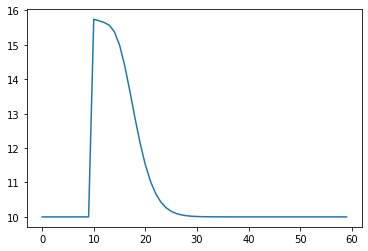

In [159]:
from scipy.interpolate import interpn
from numpy.linalg import norm
import matplotlib.pyplot as plt
mass_flows = set()
temperatures = set()
times = set()
for mass_flow, temperature, time in all_the_data.keys():
    mass_flows.add(mass_flow)
    temperatures.add(temperature)
    times.add(time)

mass_flow_range = sorted(list(mass_flows))
temperature_range = sorted(list(temperatures))
time_range = sorted(list(times))


def calculate_streamline_time_distances(streamline_points, velocity_function, pump_index):
    streamline_after_pump = streamline_points[pump_index:]
    streamline_before_pump = streamline_points[:pump_index+1][::-1]
    times_after_pump = [integrate_over_velocity(
        velocity_function, streamline_after_pump[0:i+1]) for i in range(1, len(streamline_after_pump))]
    times_before_pump = [-integrate_over_velocity(velocity_function, streamline_before_pump[0:i+1])
                         for i in range(1, len(streamline_before_pump))]
    time_distances = np.array(times_before_pump[::-1] + [0] + times_after_pump)
    return time_distances


streamline_points = np.array([
    np.arange(0, 600),
    np.full((600,), 100),
    np.full((600,), 0)]).T
streamline_normals = np.full((600, 3), np.array([0, 1, 0]))

time_distances = calculate_streamline_time_distances(
    streamline_points, get_velocity, 100)

all_points_for_the_interpolation_please = (
    mass_flow_range, temperature_range, time_range, time_distances)

points_amplitude = np.zeros((len(mass_flow_range), len(
    temperature_range), len(time_range), len(time_distances)))
points_sigma = np.zeros((len(mass_flow_range), len(
    temperature_range), len(time_range), len(time_distances)))
points_mu = np.zeros((len(mass_flow_range), len(
    temperature_range), len(time_range), len(time_distances)))
points_offset = np.zeros((len(mass_flow_range), len(
    temperature_range), len(time_range), len(time_distances)))

for n_mass_flow, mass_flow in enumerate(mass_flow_range):
    for n_temperature, temperature in enumerate(temperature_range):
        for n_time, time in enumerate(time_range):
            for n_distance, distance in enumerate(time_distances):
                points_amplitude[n_mass_flow, n_temperature, n_time, n_distance] = all_the_data[(
                    mass_flow, temperature, time)][n_distance][0]
                points_sigma[n_mass_flow, n_temperature, n_time, n_distance] = all_the_data[(
                    mass_flow, temperature, time)][n_distance][1]
                points_mu[n_mass_flow, n_temperature, n_time, n_distance] = all_the_data[(
                    mass_flow, temperature, time)][n_distance][2]
                points_offset[n_mass_flow, n_temperature, n_time, n_distance] = all_the_data[(
                    mass_flow, temperature, time)][n_distance][3]


def surrogate_temperature(observation_point, inflow_mass_flow, inflow_temperature, observation_time, streamline_points, streamline_normals, streamline_time_distances):
    """
    Parameters
    ----------
        observation_point: 3D point in simulation coordinates
    """

    nearest_streamliné_point_index = np.argmin(
        norm(observation_point- streamline_points,axis = 1))
    constants = (inflow_mass_flow, inflow_temperature,
                 observation_time, streamline_time_distances[nearest_streamliné_point_index])

    normal = streamline_normals[nearest_streamliné_point_index]
    # normal[2] = 0
    # normal = normal/norm(normal)

    distance = normal @ (observation_point -
                         streamline_points[nearest_streamliné_point_index])/75

    amplitude = interpn(all_points_for_the_interpolation_please,
                        points_amplitude, constants)
    sigma = interpn(all_points_for_the_interpolation_please,
                    points_sigma, constants)
    mu = interpn(all_points_for_the_interpolation_please, points_mu, constants)
    offset = interpn(all_points_for_the_interpolation_please,
                     points_offset, constants)

    return gauss(distance, amplitude, sigma, mu, offset)
l = []
for x in tqdm(range(0,600,10)):
    l.append(surrogate_temperature([x,100,0],3,15,6,streamline_points,streamline_normals, time_distances))
plt.plot(l)


In [161]:
width,height = 60,20
temps = np.zeros((width,height))
for n_x,x in tqdm(list(enumerate(np.linspace(0,600,width)))):
    for n_y,y in enumerate(np.linspace(0,200,height)):
        temps[n_x,n_y] = surrogate_temperature([x,y,0],3,15,12,streamline_points,streamline_normals, time_distances)

100%|██████████| 60/60 [00:07<00:00,  7.93it/s]


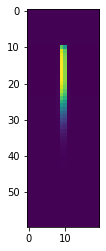

In [162]:
import matplotlib.pyplot as plt
import numpy as np
# temp = np.loadtxt("temp.tmp")
# plt.figure(figsize=(30,20))
plt.imshow(temps)
# np.savetxt("flow_3_temp_15_1year_2.temperature_field",temps)
# plt.savefig("fancy.png")

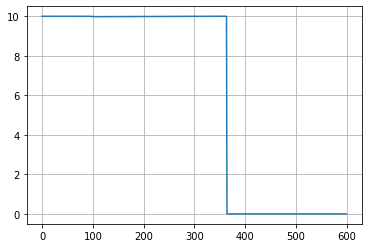

In [132]:
plt.plot(temps[...,80])
plt.grid()
# why zero 
# that's the middle line

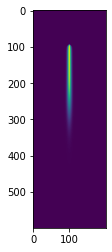

In [138]:
temps2 = np.loadtxt("flow_2_temp_15_1year.temperature_field")
plt.imshow(temps2)

  0%|          | 0/600 [00:00<?, ?it/s]


TypeError: fromiter() missing required argument 'dtype' (pos 2)